# Images and Color
## Duke Kunshan University Fall 2017
### David Brady


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
from scipy import interpolate as interp
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/home/dbrady/anaconda3/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [3]:
def grabImage(sid=1, imres=8, fm=1, cameraNumber=6):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        rows=2190
        runL=3864
        pop=np.reshape(pop[:rows*runL],(rows,runL))
    return pop

In [37]:
def demosaic(rawImage):  
    red=rawImage
    for er in range(1,2159,2):
        for odr in range(0,3862,2):
            red[er,odr]=np.mean([red[er-1,odr], red[er+1,odr]])
    for er in range(0,2160,2):
        for odr in range(1,3862,2):
            red[er,odr]=np.mean([red[er,odr-1], red[er,odr+1]])
    for er in range(1,2160,2):
        for odr in range(1,3862,2):
            red[er,odr]=np.mean([red[er-1,odr-1],red[er+1,odr+1]])
    blue=rawImage
    for er in range(1,2160,2):
        for odr in range(2,3862,2):
            blue[er,odr]=np.mean([blue[er,odr-1], blue[er,odr+1]])
    for er in range(2,2160,2):
        for odr in range(1,3862,2):
            blue[er,odr]=np.mean([blue[er-1,odr], blue[er+1,odr]])
    for er in range(2,2160,2):
        for odr in range(2,3862,2):
            blue[er,odr]=np.mean([blue[er-1,odr-1],blue[er+1,odr+1]])
    green=rawImage;
    for er in range(0,2159,2):
        for odr in range(0,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(1,2160,2):
        for odr in range(1,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    imageOut=np.dstack((red,green,blue))
    imageOut=imageOut[0:2159,0:3840,:]
    imageOut=imageOut-np.min(imageOut)
    imageOut=255*np.tanh(2*imageOut/np.max(imageOut))
    imageOut=imageOut.astype(np.uint8)
    return imageOut
            
    

In [4]:
def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]#
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI
    

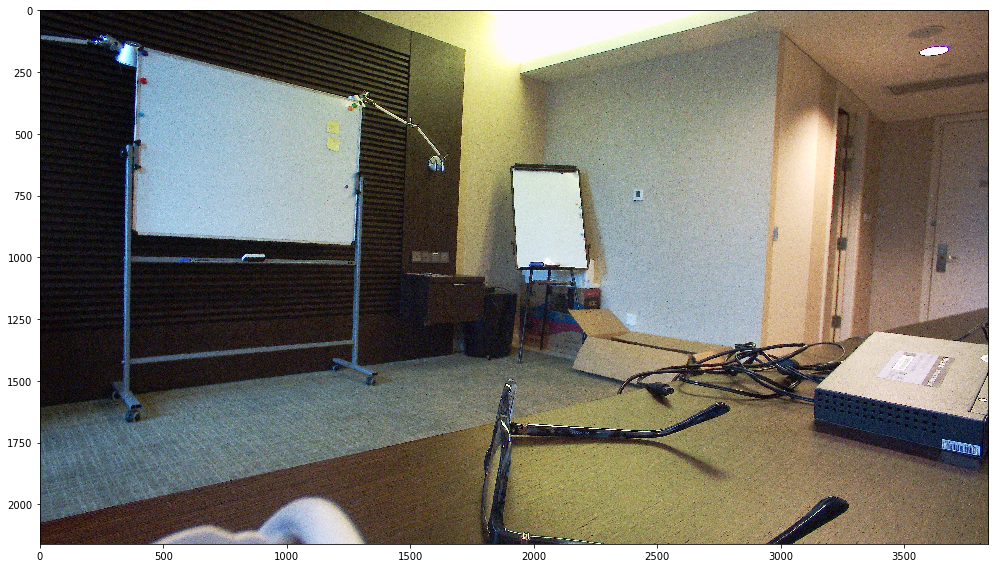

In [23]:
a = grabImage(fm=1,sid=0)
imio.imshow(a)


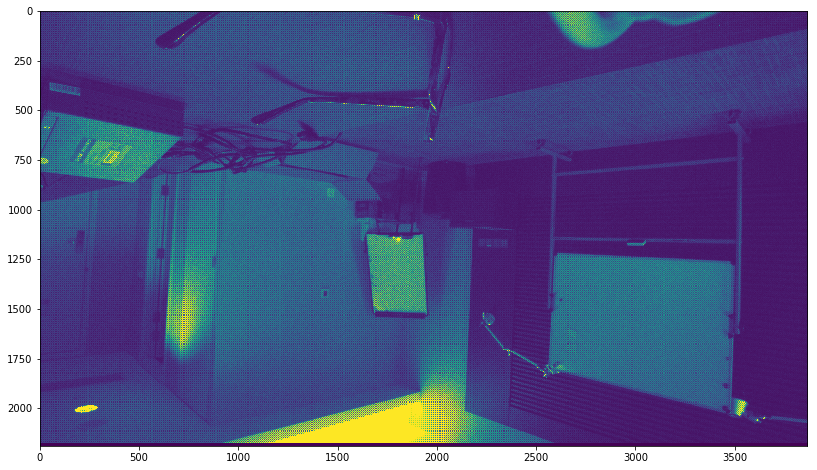

In [24]:
a = grabImage(fm=2, sid=0)
plt.imshow(a)

In [27]:
test=demosaic(a)

In [33]:
np.max(test)

15642

In [30]:
imio.imshow(test[:,:,0])

In [36]:
hist,bins=np.histogram(test[:,:,2],np.linspace(0,np.max(test)))
plt.plot(hist)

In [12]:
b=adjustColor(test,rc=1,bc=1,gc=.6,gain=2,contrast=1.2)

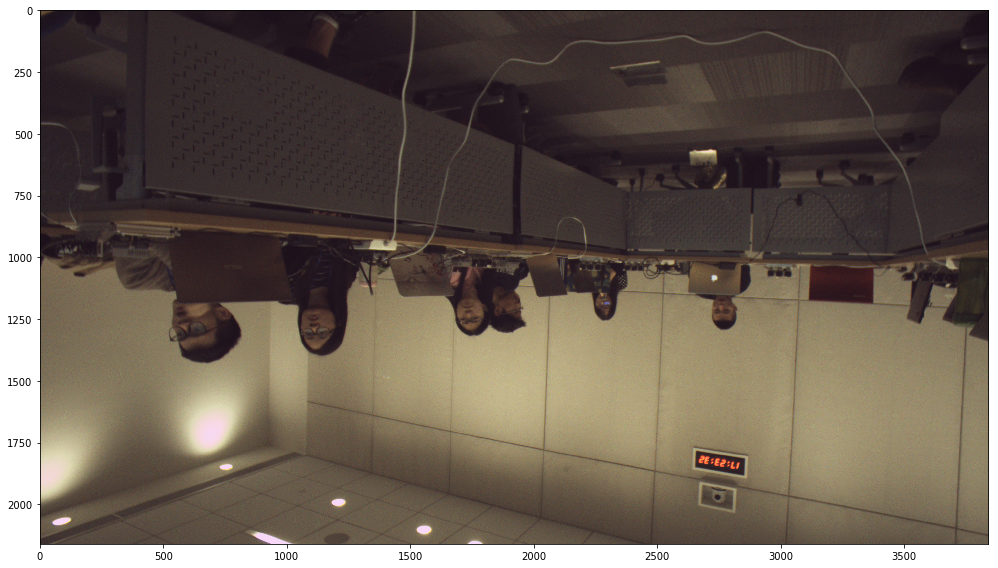

In [13]:
imio.imshow(b)

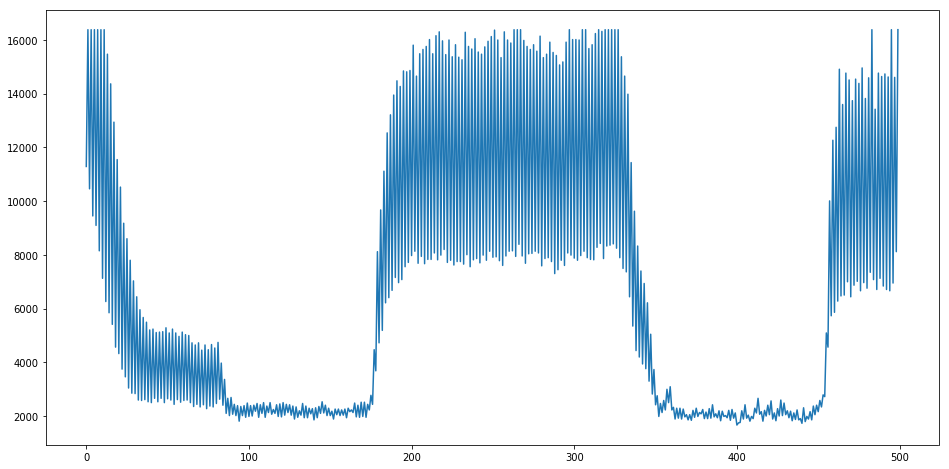

In [27]:
plt.plot(a[1750,1500:2000])

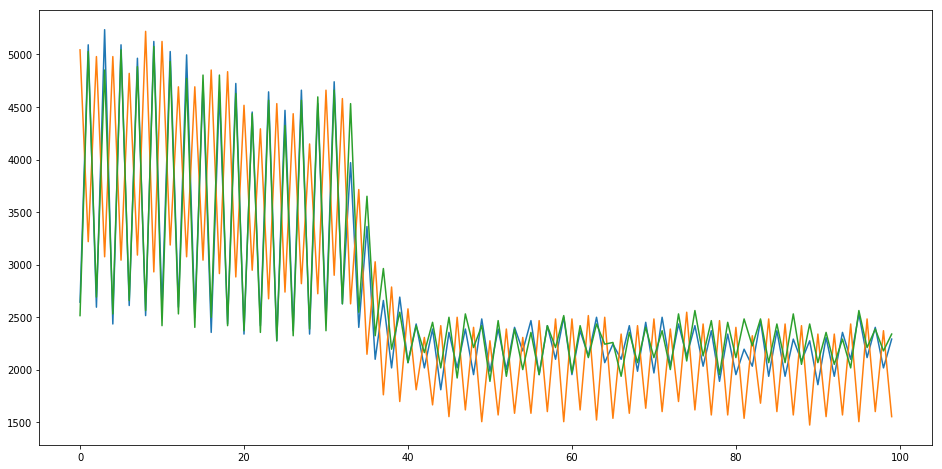

In [37]:
plt.plot(np.arange(0,100),np.transpose(a[1750:1753,1550:1650]))

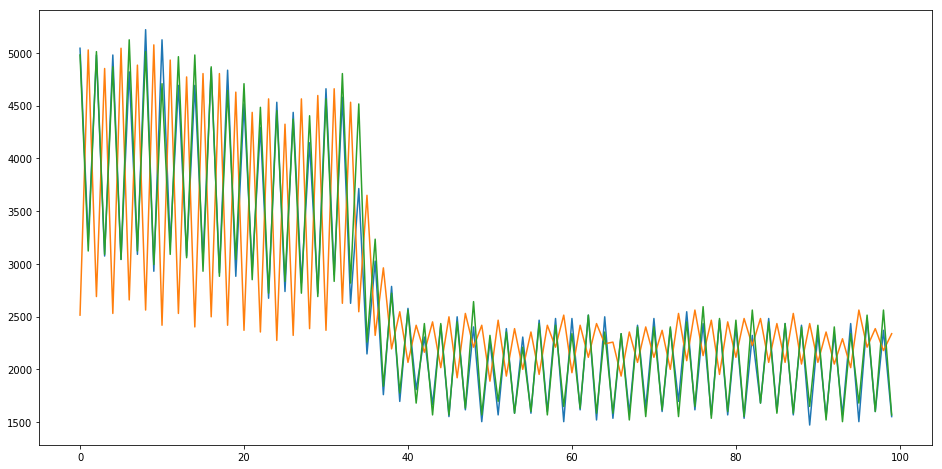

In [41]:
plt.plot(np.arange(0,100),np.transpose(a[1751:1754,1550:1650]))

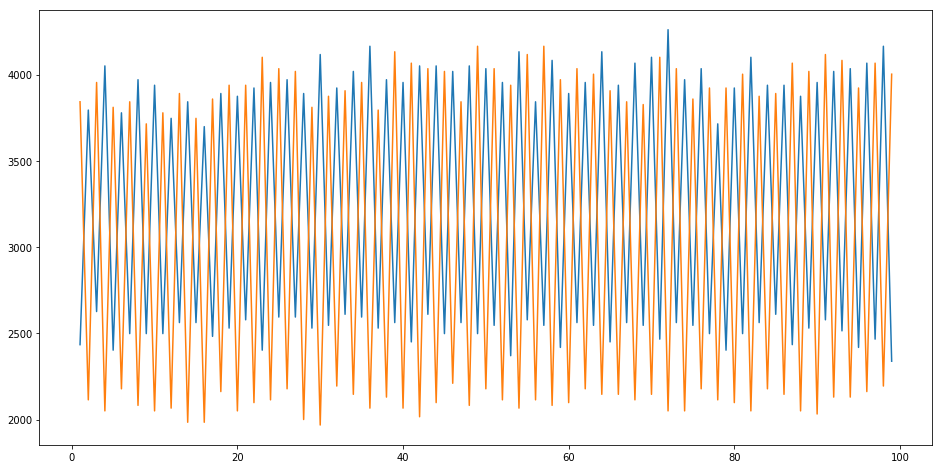

In [53]:
plt.plot(np.arange(1,100),np.transpose(a[1:3,1:100]))